# I- Introduction:
Aprés avoir testé the state of the art model (Bert) nous alllons essayer dans ce projet d'utiliser deux types différents de deep neural network: Convolutional Neural Network (CNN) et Long Short Term Memory Network (LSTM), qui est une variante des Recurrent Neural Networks pour affiner rapidement et efficacement un modèle de classification des logs de de Thunderbird supercomputer, où notre objectif sera de détecter les anomalies dans des futurs logs.

* **Dataset** - nous allons utiliser une DT open Source des logs de Thunderbird supercomputer(contient 211,212,192 logs mais nous allons uiliser seulement 221220 logs),il est sous forme d'un Filelog donc on avait besoin d'utiliser excel(On peut utiliser Python mais excel reste simple) pour insérer les logs dans des dataframes.

* **Objectif** - developper une solution qui permet de detecter les anomalies dans les logs.

* **Methodologie** - nous allons considerer comme nous avons un probleme de text classification et construire un deep learning model pour attiendre l'objectif.

# II- Different Models:

Il existe plusieurs types de modèles qui pourraient être utilisés pour créer la solution de la classification de texte parmi ces solutions on trouve:


*   **1D- Conv Net** : 
les CNN peuvent être utilisés pour la classification des textes. ils sont plus rapides à s'entraîner.

*   **Modèles basés sur RNN (LSTM, GRU)** :  ils peuvent capturer la nature séquentielle d'un texte. Mais ils sont plus lent à s'entraîner.

* **Modèles basés sur des transformers (BERT, GPT2)** -
Les modèles basés sur des transformers exploite plusieurs unités Transformer et un mécanisme d'attention à multihead.

####Dans ce projet nous allons focaliser sur un model basé sur RNN(LSTM) et un autre basé sur les CNN.


# III- Data Preprocessing

### 1. Importing libraries and modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from numpy import array
import keras 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
from google.colab import drive
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from sklearn.metrics import accuracy_score

###2. Loading Data

####**Importing files from Google Drive in Colab**
notre dataset est stockée dans Google Drive donc nous avons besoin de 
lier notre compte Google Drive avec notre notebook.
1. La première étape consiste à monter notre Google Drive en exécutant le code en dessous.
2.  nous obtenons le code d'autorisation en nous connectant à notre compte Google.
3.   nous collons le code d'autorisation et nous appuyons sur Entrée.

In [2]:
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
PATH_data=r'/gdrive/My Drive/thunderbird V.xlsx' 

In [4]:
data = pd.read_excel(PATH_data)

In [5]:
data.to_csv(r'/gdrive/My Drive/thunderbird v.csv')

In [6]:
df = pd.read_csv(r'/gdrive/My Drive/thunderbird v.csv') 

In [7]:
df.head()

,Unnamed: 0,log,label
0,0,- 1131965931 2005.11.14 an933 Nov 14 02:58:51 ...,0
1,1,- 1131965931 2005.11.14 an933 Nov 14 02:58:51 ...,0
2,2,- 1131965931 2005.11.14 an933 Nov 14 02:58:51 ...,0
3,3,- 1131965931 2005.11.14 an933 Nov 14 02:58:51 ...,0
4,4,- 1131965931 2005.11.14 an933 Nov 14 02:58:51 ...,0


In [8]:
del df['Unnamed: 0']

In [9]:
df.shape

(221220, 2)

* Vérifier les valeurs nulles

In [10]:
df.isnull().values.any()

False

* Nous supprimons ensuite les caractères non alphanumériques.

In [11]:
def clean_data(log):
    log = re.sub("'", "", log)
    log = re.sub("-", "", log)
    log = re.sub("(\\W)+", " ", log)
    log = log.lower()
    return log

df['log'] = df['log'].apply(clean_data)

* Split the dataset into train set 80% et test sets 20%)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['log'],df['label'], test_size=0.2,random_state=42)

# IV- Preparing the Embedding Layer

nous utiliserons la classe Tokenizer du module keras.preprocessing.text pour créer un dictionnaire de word-to-index . Dans le dictionnaire, chaque mot est utilisé comme clé, tandis qu'un index unique correspondant est utilisé comme valeur pour la clé.

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Nous fixons la taille maximale à 114. Les listes de taille supérieure à 114 seront tronquées à 114. Pour les listes dont la longueur est inférieure à 114, nous ajouterons 0 à la fin de la liste jusqu'à ce qu'elle atteigne la longueur maximale.

In [14]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 114

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Nous utiliserons GloVe embeddings pour créer feature matrix, j'ai essayé d'importer Glove sur mon drive
* vous pouvez la trouver sur : https://drive.google.com/file/d/17PIgUPWrXOLFbUYqTAnl1cgWqnWHgX1B/view?usp=sharing

In [15]:
from numpy import array
from numpy import asarray
from numpy import zeros

glove_path=r'/gdrive/My Drive/glove.6B.100d.txt'
embeddings_dictionary = dict()
glove_file = open(glove_path, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

Enfin, nous allons créer une embedding matrix où chaque numéro de ligne correspondra à l'index du mot. La matrice aura 100 colonnes où chaque colonne contiendra les embeddings de mots GloVe.

In [16]:
embedding_matrix = zeros((vocab_size,100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# V- CNN model

* Construire le model

In [34]:
from keras.layers import MaxPooling1D,Conv1D,GlobalMaxPooling1D
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Input, merge,Concatenate



###Building the Model. 
input_tensor = Input(shape=(114,))
# Créer un embedding layer(2D)
input_layer= Embedding(vocab_size,100, weights=[embedding_matrix], input_length=maxlen , trainable=False)(input_tensor)
#liste où on va stocker l'output
uni_vec = []
#nous allons utiliser 3 filtres avec des n-grams différents( 2-grams, 3-grams, 4-grams)
filter_sizes = (2,3,4)
for ks in filter_sizes:
    #applique 3 convolutions différents à l'embedding layer
    conv_layer= Conv1D(128, kernel_size=ks, activation='relu')(input_layer)
    maxpool_layer = MaxPooling1D(4)(conv_layer)
    flat_layer= Flatten()(maxpool_layer)
    uni_vec.append(flat_layer)

# concatiner les outputs 
single_feature_vector = keras.layers.concatenate(uni_vec)
#fully Connected Layers
dense = Dense(128, activation='relu')(single_feature_vector)
dense2 = Dense(128, activation='relu')(dense)
out = Dense(1, activation='sigmoid')(dense2)
model = Model(inputs=input_tensor, outputs=out)



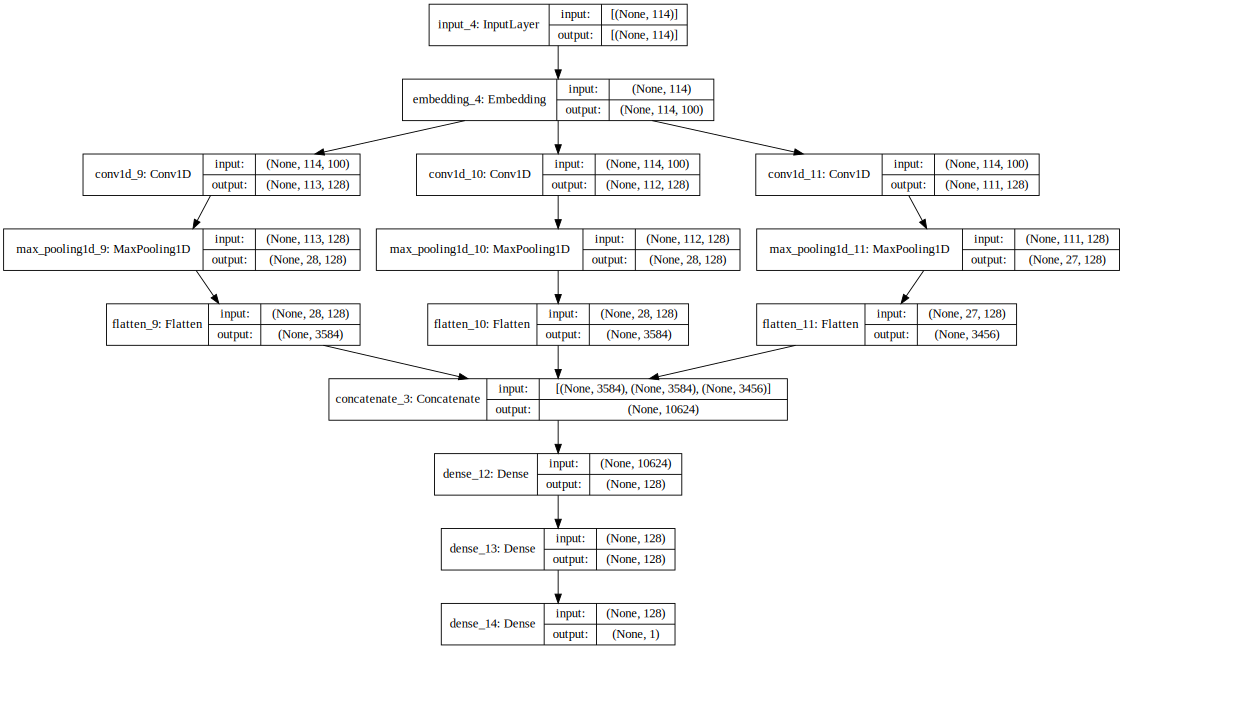

In [35]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

* compiler le model

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

* train le model

In [20]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
2213/2213 [==============================] - 64s 9ms/step - loss: 0.0038 - acc: 0.9983 - val_loss: 2.5950e-08 - val_acc: 1.0000
Epoch 2/10
2213/2213 [==============================] - 20s 9ms/step - loss: 1.8217e-08 - acc: 1.0000 - val_loss: 6.4437e-09 - val_acc: 1.0000
Epoch 3/10
2213/2213 [==============================] - 20s 9ms/step - loss: 5.3575e-09 - acc: 1.0000 - val_loss: 4.2943e-09 - val_acc: 1.0000
Epoch 4/10
2213/2213 [==============================] - 20s 9ms/step - loss: 3.9747e-09 - acc: 1.0000 - val_loss: 3.5683e-09 - val_acc: 1.0000
Epoch 5/10
2213/2213 [==============================] - 20s 9ms/step - loss: 3.3755e-09 - acc: 1.0000 - val_loss: 3.2130e-09 - val_acc: 1.0000
Epoch 6/10
2213/2213 [==============================] - 20s 9ms/step - loss: 3.1334e-09 - acc: 1.0000 - val_loss: 2.9500e-09 - val_acc: 1.0000
Epoch 7/10
2213/2213 [==============================] - 19s 9ms/step - loss: 2.8809e-09 - acc: 1.0000 - val_loss: 2.8080e-09 - val_acc: 1.0000
Epo

* evaluer le model sur test set

In [21]:
score = model.evaluate(X_test, y_test, verbose=1)

1383/1383 [==============================] - 5s 3ms/step - loss: 1.8194e-05 - acc: 1.0000


In [22]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 1.8193921277998015e-05
Test Accuracy: 0.9999774098396301


## **Comme vous pouvez voir nous avons atteindre une performance de 99,99% avec le CNN model** 

* Tracons la différence de loss et accuracy entre train set et test set

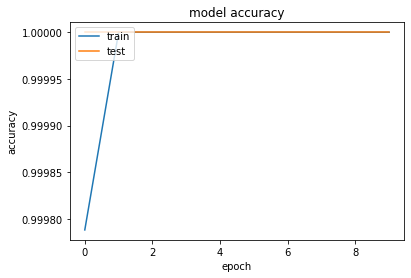

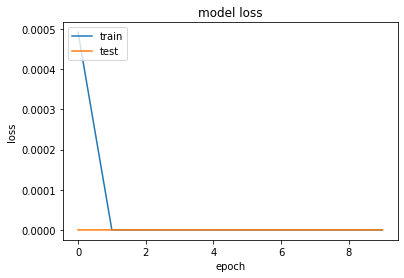

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# VI- LSTM

* Constriure le model

In [24]:
model1 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model1.add(embedding_layer)
model1.add(LSTM(128))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


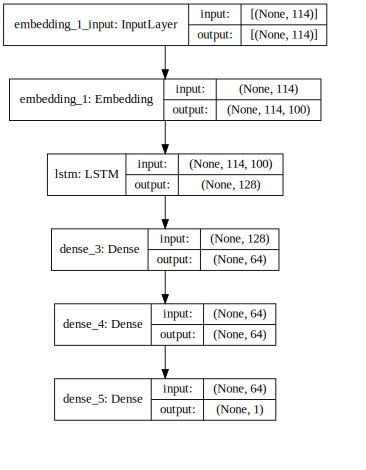

In [25]:
SVG(model_to_dot(model1, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

* train model

In [26]:
history = model1.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
2213/2213 [==============================] - 31s 12ms/step - loss: 0.0493 - acc: 0.9839 - val_loss: 0.4345 - val_acc: 0.8437
Epoch 2/10
2213/2213 [==============================] - 26s 12ms/step - loss: 0.4348 - acc: 0.8428 - val_loss: 0.0097 - val_acc: 0.9988
Epoch 3/10
2213/2213 [==============================] - 26s 12ms/step - loss: 0.0988 - acc: 0.9651 - val_loss: 2.7446e-04 - val_acc: 1.0000
Epoch 4/10
2213/2213 [==============================] - 26s 12ms/step - loss: 0.0067 - acc: 0.9987 - val_loss: 9.5517e-04 - val_acc: 0.9998
Epoch 5/10
2213/2213 [==============================] - 26s 12ms/step - loss: 0.0012 - acc: 0.9998 - val_loss: 1.8103e-04 - val_acc: 1.0000
Epoch 6/10
2213/2213 [==============================] - 26s 12ms/step - loss: 2.4744e-04 - acc: 1.0000 - val_loss: 0.2756 - val_acc: 0.8437
Epoch 7/10
2213/2213 [==============================] - 26s 12ms/step - loss: 0.0613 - acc: 0.9759 - val_loss: 5.9279e-04 - val_acc: 0.9999
Epoch 8/10
2213/2213 [======

* evaluate model

In [27]:
score = model1.evaluate(X_test, y_test, verbose=1)

1383/1383 [==============================] - 6s 5ms/step - loss: 0.1022 - acc: 0.9844


In [28]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.1021546944975853
Test Accuracy: 0.9843594431877136


## **Comme vous pouvez voir nous avons atteindre une performance de 98,43% avec le LSTM model**

* Tracons la différence de loss et accuracy entre train set et test set

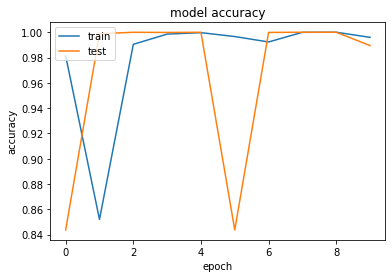

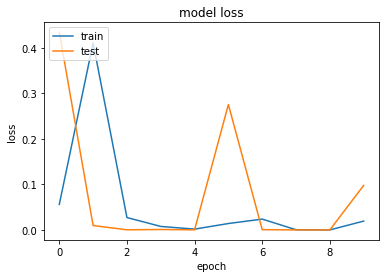

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()